In [1]:
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import random, shutil
import pickle

In [2]:
import numpy
np.random.seed(1212)
import keras
from keras.models import Model
from keras.layers import *
from keras import optimizers
from keras.layers import Input, Dense
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format('channels_first')
from keras.models import model_from_json

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

## MAKING TRAINING FOLDER

In [4]:
firstdir ='D:/SD/extracted_images/'
tardir ='D:/SD/Train_folder_new/'
pathdir = os.listdir(firstdir)

In [5]:
reqdir = ['0', '1', '2', '3', '4', '5', '6', '8', '9','(', ')', '+','-','=','x', 'y', 'z']

In [6]:
path_from = []
path_to = []
for i in reqdir:
    path_from.append(firstdir + i)
    path_to.append(tardir + i)

In [ ]:
print(path_from)
print(path_to)

In [ ]:
j = 0
for i in path_from:
    sample = random.sample(os.listdir(i), 3000)
    for name in sample:
        shutil.move(i+'/'+name, path_to[j]+'/'+name)
    j += 1

## DATA EXTRACTION 

In [7]:
def load_images_from_folder(folder):
    train_data=[]
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        a = img_gray.max()
        if img is not None:
            _, thresh = cv2.threshold(img_gray, a/2+60, a,cv2.THRESH_BINARY_INV)
            ctrs,ret=cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            cnt = sorted(ctrs, key = cv2.contourArea, reverse = True)
            #c_0 = cnt[0]
            #x, y, w, h = cv2.boundingRect(c_0)
            im_resize = cv2.resize(thresh,(28,28))
            train_data.append(im_resize)
    return train_data

In [8]:
data=[]

In [9]:
data = load_images_from_folder('D:/SD/Train_folder_new/0')
for i in range(0,len(data)):
    data[i]=np.append(data[i],['0'])
   
print(len(data))

3000


In [10]:
path_new = path_to[1:]
path_new.append('D:/SD/Train_folder_new/7')
print(path_new)

['D:/SD/Train_folder_new/1', 'D:/SD/Train_folder_new/2', 'D:/SD/Train_folder_new/3', 'D:/SD/Train_folder_new/4', 'D:/SD/Train_folder_new/5', 'D:/SD/Train_folder_new/6', 'D:/SD/Train_folder_new/8', 'D:/SD/Train_folder_new/9', 'D:/SD/Train_folder_new/(', 'D:/SD/Train_folder_new/)', 'D:/SD/Train_folder_new/+', 'D:/SD/Train_folder_new/-', 'D:/SD/Train_folder_new/=', 'D:/SD/Train_folder_new/x', 'D:/SD/Train_folder_new/y', 'D:/SD/Train_folder_new/z', 'D:/SD/Train_folder_new/7']


In [11]:
j = 1
for i in path_new:
    data1=load_images_from_folder(i)
    for k in range(0,len(data1)):
        data1[k]=np.append(data1[k],[str(j)])
    data=np.concatenate((data,data1))
    j += 1

In [12]:
print(data.shape)

(53909, 785)


In [13]:
df=pd.DataFrame(data,index=None)
df.to_csv('train_final.csv',index=False)

In [14]:
df_train=pd.read_csv('train_final.csv',index_col=False)
labels=df_train[['784']]

In [15]:
df_train.drop(df_train.columns[[784]],axis=1,inplace=True)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,241,178,178,178,...,59,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,178,178,178,...,195,41,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,186,178,178,178,178,178,...,0,0,0,0,0,0,0,0,0,0


In [16]:
labels=np.array(labels)

In [17]:
from keras.utils.np_utils import to_categorical
cat=to_categorical(labels,num_classes=18)

In [18]:
l=[]
for i in range(53909):
    l.append(np.array(df_train[i:i+1]).reshape(28,28,1))

In [19]:
y = np.array(l)

In [20]:
from sklearn.model_selection import train_test_split
data_train, data_test, cat_train, cat_test = train_test_split(y, cat, test_size=0.3, random_state=42)

In [21]:
print(data_train.shape)
print(data_test.shape)

(37736, 28, 28, 1)
(16173, 28, 28, 1)


## TRAINING MODEL 

In [22]:
data_train = (data_train / 255) - 0.5
data_test = (data_test / 255) - 0.5

In [23]:
num_filters = 8
filter_size = 3
pool_size = 2

In [24]:
model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(28, 28,1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(18, activation='softmax'),
])

In [25]:
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [28]:
model.fit(
  data_train,
  cat_train,
  epochs=5,
  validation_data=(data_test, cat_test),
)

Epoch 1/5
1180/1180 [==============================] - 4s 4ms/step - loss: 0.1465 - accuracy: 0.9622 - val_loss: 0.2141 - val_accuracy: 0.9429
Epoch 2/5
1180/1180 [==============================] - 4s 4ms/step - loss: 0.1368 - accuracy: 0.9653 - val_loss: 0.2116 - val_accuracy: 0.9442
Epoch 3/5
1180/1180 [==============================] - 4s 4ms/step - loss: 0.1274 - accuracy: 0.9685 - val_loss: 0.2104 - val_accuracy: 0.9447
Epoch 4/5
1180/1180 [==============================] - 4s 4ms/step - loss: 0.1195 - accuracy: 0.9699 - val_loss: 0.1979 - val_accuracy: 0.9482
Epoch 5/5
1180/1180 [==============================] - 4s 4ms/step - loss: 0.1121 - accuracy: 0.9719 - val_loss: 0.2033 - val_accuracy: 0.9469


In [29]:
model_json = model.to_json()
with open("model_n_final.json", "w") as json_file:
    json_file.write(model_json)

In [30]:
model.save_weights('cnn.h5')
model.load_weights('cnn.h5')

In [31]:
predictions = model.predict(data_test[:5])

In [32]:
print(np.argmax(predictions, axis=1))

[13 14  8 10  9]


In [33]:
print(cat_test[:5])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


## TESTING THE MODEL 

In [34]:
json_file = open('model_n_final.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("cnn.h5")

In [161]:
'''
img = cv2.imread('D:/SD/test.jpeg',cv2.IMREAD_GRAYSCALE)
#kernel = np.ones((3,3),np.uint8)
cv2.imshow("wo",img)
cv2.waitKey(0)
cv2.destroyAllWindows()
#erosion = cv2.erode(img,kernel,iterations = 3)
#dilation = cv2.dilate(img,kernel,iterations = 1)
#img=dilation
if img is not None:
    #images.append(img)
    img=~img
    ret,thresh=cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    ctrs,ret=cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    w=int(28)
    h=int(28)
    train_data=[]
    #print(len(cnt))
    rects=[]
    for c in cnt :
        x,y,w,h= cv2.boundingRect(c)
        rect=[x,y,w,h]
        rects.append(rect)
    #print(rects)
    bool_rect=[]
    for r in rects:
        l=[]
        for rec in rects:
            flag=0
            if rec!=r:
                if r[0]<(rec[0]+rec[2]+10) and rec[0]<(r[0]+r[2]+10) and r[1]<(rec[1]+rec[3]+10) and rec[1]<(r[1]+r[3]+10):
                    flag=1
                l.append(flag)
            if rec==r:
                l.append(0)
        bool_rect.append(l)
    #print(bool_rect)
    dump_rect=[]
    for i in range(0,len(cnt)):
        for j in range(0,len(cnt)):
            if bool_rect[i][j]==1:
                area1=rects[i][2]*rects[i][3]
                area2=rects[j][2]*rects[j][3]
                if(area1==min(area1,area2)):
                    dump_rect.append(rects[i])
    #print(len(dump_rect)) 
    final_rect=[i for i in rects if i not in dump_rect]
    #print(final_rect)
    for r in final_rect:
        x=r[0]
        y=r[1]
        w=r[2]
        h=r[3]
        im_crop =thresh[y:y+h+10,x:x+w+10]
        

        im_resize = cv2.resize(im_crop,(28,28))
        cv2.imshow("work",im_resize)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        im_resize=np.reshape(im_resize,(1,28,28))
        train_data.append(im_resize)
'''

In [ ]:
'''
print(train_data[0])
'''

In [ ]:
'''
s=''
for i in range(len(train_data)):
    train_data[i]=np.array(train_data[i])
    train_data[i]=train_data[i].reshape(1,28,28,1)
    result=loaded_model.predict_classes(train_data[i])
    if(result[0]==10):
        s=s+'-'
    if(result[0]==11):
        s=s+'+'
    if(result[0]==12):
        s=s+'*'
    if(result[0]==0):
        s=s+'0'
    if(result[0]==1):
        s=s+'1'
    if(result[0]==2):
        s=s+'2'
    if(result[0]==3):
        s=s+'3'
    if(result[0]==4):
        s=s+'4'
    if(result[0]==5):
        s=s+'5'
    if(result[0]==6):
        s=s+'6'
    if(result[0]==7):
        s=s+'7'
    if(result[0]==8):
        s=s+'8'
    if(result[0]==9):
        s=s+'9'    
print(s)
'''

In [463]:
img_sep = load_images_from_folder('D:/SD/Input_fin')
for i in range(0,len(img_sep)):
    img_sep[i]=np.append(img_sep[i],['0'])
   
print(len(img_sep))

4


In [464]:
print(np.array(img_sep).shape)

(4, 785)


In [465]:
df1=pd.DataFrame(img_sep,index=None)
df1.to_csv('IP_final.csv',index=False)
df_ip=pd.read_csv('IP_final.csv',index_col=False)
df_ip.drop(df_ip.columns[[784]],axis=1,inplace=True)
df_ip.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [466]:
l1=[]
for i in range(4):
    l1.append(np.array(df_ip[i:i+1]).reshape(28,28,1))

In [467]:
p = np.array(l1)

In [468]:
print(p.shape)

(4, 28, 28, 1)


In [469]:
p = (p / 255) - 0.5

In [470]:
prediction1 = model.predict(p)
pred = np.argmax(prediction1, axis=1)

In [492]:
s=''
for result in pred:
    if(result==0):
        s = s+'0'
    if(result==1):
        s = s+'1'
    if(result==2):
        s = s='2'
    if(result==3):
        s = s+'3'
    if(result==4):
        s = s+'4'
    if(result==5):
        s = s+'5'
    if(result==6):
        s = s+'6'
    if(result==7):
        s = s+'8'
    if(result==8):
        s = s+'9'
    if(result==9):
        s = s+'('
    if(result==10):
        s = s+')'
    if(result==11):
        s = s+'+'
    if(result==12):
        s = s+'-'
    if(result==13):
        s = s+'='
    if(result==14):
        s = s+'x'
    if(result==15):
        s = s+'y'
    if(result==16):
        s = s+'z'
    if(result==17):
        s = s+'7'

In [493]:
print(s)

xy=1


In [501]:
val = ['x','y','z']
for m in val:
    u = s.find(m)
    if u != -1:
        if s[u+1] in val:
            if s[u+2]=='=':
                s1 = s[u+3:] + '/' + m

In [502]:
print(s1)

1/x


In [512]:
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = eval(formula)

    fig = plt.figure()
    
    ax = fig.add_subplot(1, 1, 1)

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    plt.plot(x, y)
    plt.show()

<string>:1: RuntimeWarning: divide by zero encountered in true_divide


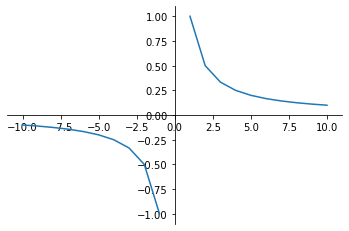

In [513]:
graph(s1,range(-10, 11))